In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterSciNotation

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
sns.set_style('whitegrid')
rcParams['figure.dpi'] = 300
rcParams['figure.figsize'] = (4, 3)
rcParams['grid.linewidth'] = 0.5
rcParams['grid.linestyle'] = 'dashed'
rcParams['legend.fancybox'] = False
rcParams['mathtext.fontset'] = 'stix'
rcParams['xtick.major.pad']='0'
rcParams['ytick.major.pad']='1'

dpi = 150


c6 = ['#c4bae2','#40ada6','#3c4ebf',  
        '#e3a600', '#edb1a3', '#d6543a',]
pretty_palette = [c6[c] for c in range(6) if c in [1,2,3,5]]

In [3]:
merf_df = pd.read_csv('../results/MERFISH_scaling.csv', index_col=0)
cite_df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv', index_col=0)
larry_df = pd.read_csv('../results/LARRY_scaling.csv', index_col=0)

dfs = [merf_df, cite_df, larry_df]

for df in dfs:
    df.replace("RandomProjection", "Rand. proj.", inplace=True)
    df.replace("nanoTxformer", "Txformer", inplace=True)

hue_order = ["VAE", "PCA", "Txformer", "Rand. proj."]

In [4]:
def add_delta_mi(df, mi_column):
    avg_random_proj = (
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .transform("mean")
    )
    df["avg_random_proj"] = df["UMI per cell"].map(
        df[df["Method"] == "Rand. proj."]
        .groupby("UMI per cell")[mi_column]
        .mean()
    )
    df[f"delta {mi_column}"] = df[mi_column] - df['avg_random_proj']
    df[f"Info gain ({mi_column})"] = df[f"delta {mi_column}"] / np.log10(df['Cell number'])
    return df

cite_df = add_delta_mi(cite_df, "Protein MI")
cite_df = add_delta_mi(cite_df, "Cell type fine MI")
merf_df = add_delta_mi(merf_df, "Spatial neighborhood MI")
larry_df = add_delta_mi(larry_df, "Clonal MI")

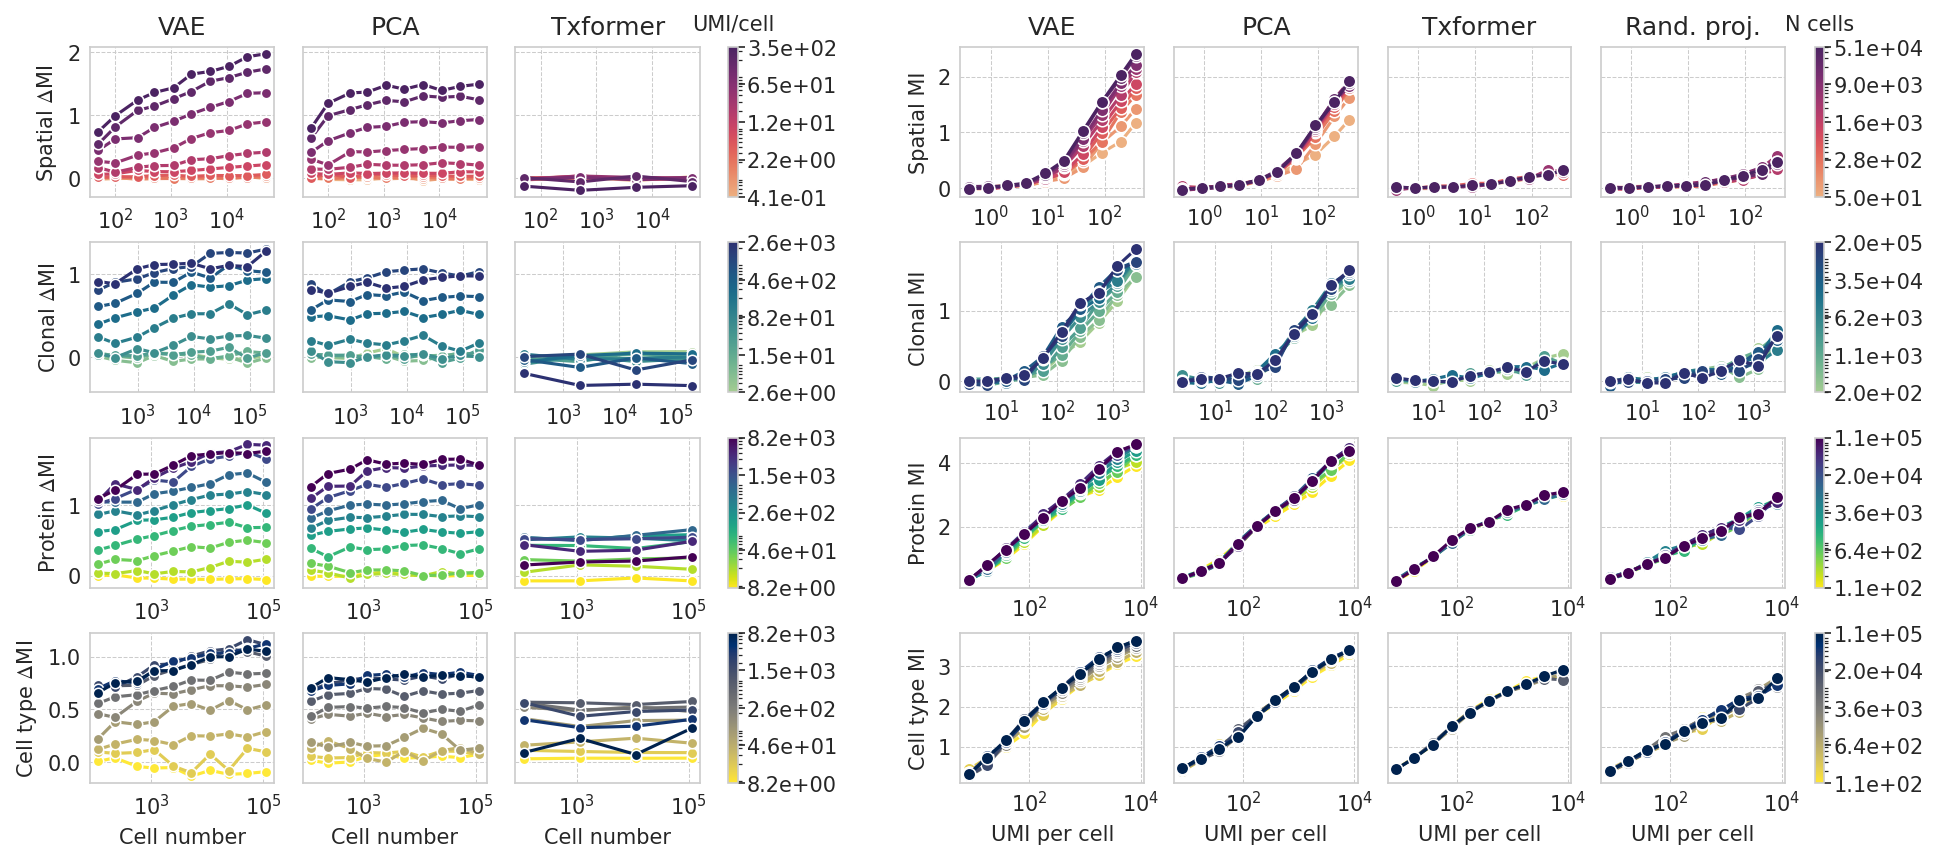

In [36]:
big_fig = plt.figure(figsize=(13, 6.5), dpi=dpi)

figs = big_fig.subfigures(1, 2, width_ratios=[3, 4], wspace=0.0)

fs = 10

# prepare the data for grid
metrics = ['Spatial neighborhood MI', 'Clonal MI', 'Protein MI', 'Cell type fine MI']
names = ['Spatial MI', 'Clonal MI', 'Protein MI', 'Cell type MI']
model_types = hue_order
palettes = ['flare', 'crest', 'viridis_r', 'cividis_r']  # distinct palettes for rows

# number of legend entries
n_legend_colors = 5

fig = figs[1]

axes = fig.subplots(4,5, sharex=False, sharey='row', 
                    gridspec_kw = {'width_ratios':[1,1,1,1,0.05], 'wspace':0.2, 'hspace':0.3})

# add subplots and colorbars
for row, (metric, palette) in enumerate(zip(metrics, palettes)):
    for col, method in enumerate(model_types):
        ax = axes[row][col]
        
        # filter data by metric
        if metric == 'Spatial neighborhood MI':
            data = merf_df
        elif metric == 'Clonal MI':
            data = larry_df
        else:  # Protein MI or Cell type fine MI
            data = cite_df
        
        # plot with hue by 'Cell number' and log-normalized hue
        norm = LogNorm(vmin=data['Cell number'].min(), vmax=data['Cell number'].max())
        sns.lineplot(
            data=data[data['Method'] == method],
            x='UMI per cell', y=metric,
            hue='Cell number', hue_norm=norm,
            marker='o', palette=palette, ax=ax, legend=False
        )

        # set column titles
        if row == 0:
            ax.set_title(method)

        if row != 3:
            ax.set_xlabel('')
        
        # set row labels
        if col == 0:
            ax.set_ylabel(names[row])
        
        ax.set_xscale('log')

    # create colorbar for the row
    vmin, vmax = data['Cell number'].min(), data['Cell number'].max()
    color_norm = LogNorm(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=color_norm)
    sm.set_array([])
    
    axes[row, -1].remove()
    # add the colorbar next to the last column of the row
    cbar_ax = fig.add_subplot(4, 5, 5+5*row)
    ticks = np.logspace(np.log10(vmin), np.log10(vmax), n_legend_colors)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=ticks)
    cbar.ax.set_yticklabels([f"{t:.1e}" for t in ticks], fontsize=fs)
    if row == 0:
        cbar.ax.set_title("N cells", fontsize=fs, pad=8)
    

metrics = ['delta Spatial neighborhood MI', 'delta Clonal MI', 
           'delta Protein MI', 'delta Cell type fine MI']
names = [r'Spatial $\Delta$MI', r'Clonal $\Delta$MI', r'Protein $\Delta$MI', r'Cell type $\Delta$MI']
model_types = hue_order[:-1]
palettes = ['flare', 'crest', 'viridis_r', 'cividis_r']  # distinct palettes for rows


# set up gridspec for equal subplot widths
fig = figs[0]

axes = fig.subplots(4,4, sharex=False, sharey='row', 
                    gridspec_kw = {'width_ratios':[1,1,1,0.05], 'wspace':0.2, 'hspace':0.3})

# add subplots and colorbars
for row, (metric, palette) in enumerate(zip(metrics, palettes)):
    for col, method in enumerate(model_types):
        ax = axes[row][col]
        
        # filter data by metric
        if metric == 'delta Spatial neighborhood MI':
            data = merf_df
        elif metric == 'delta Clonal MI':
            data = larry_df
        else:  # Protein MI or Cell type fine MI
            data = cite_df
        
        # plot with hue by 'Cell number' and log-normalized hue
        norm = LogNorm(vmin=data['UMI per cell'].min(), vmax=data['UMI per cell'].max())
        sns.lineplot(
            data=data[data['Method'] == method],
            hue='UMI per cell', y=metric,
            x='Cell number', hue_norm=norm, markersize=5,
            marker='o', palette=palette, ax=ax, legend=False
        )
        

        # set column titles
        if row == 0:
            ax.set_title(method)


        if row != 3:
            ax.set_xlabel('')        
        
        # set row labels
        if col == 0:
            ax.set_ylabel(names[row])
        
        ax.set_xscale('log')
        ax.tick_params(axis='x', direction='inout', length=10)

    # create colorbar for the row
    vmin, vmax = data['UMI per cell'].min(), data['UMI per cell'].max()
    color_norm = LogNorm(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=palette, norm=color_norm)
    sm.set_array([])
    
    axes[row, -1].remove()
    # add the colorbar next to the last column of the row
    cbar_ax = fig.add_subplot(4, 4, 4+4*row)
    ticks = np.logspace(np.log10(vmin), np.log10(vmax), n_legend_colors)
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', ticks=ticks)
    cbar.ax.set_yticklabels([f"{t:.1e}" for t in ticks], fontsize=fs)
    if row == 0:
        cbar.ax.set_title("UMI/cell", fontsize=fs, pad=8)

plt.show()
